#### Rate network :  Fig.1E. with presynaptic inhibition

In [1]:
#Import all packages required
import numpy as np
import time
import matplotlib.pyplot as plt
import random
import numba
import numba.types as nt
from numba import jit,prange
import argparse
%matplotlib inline

In [2]:
def rate_network_params():
    # Function for defining all the rate network parameters defined on the paper
    
    parser = argparse.ArgumentParser()
    parser.add_argument('-Ne','--Ne',action="store",default=1024,type=int,help="Number of excitatory neurons")
    parser.add_argument('-Ni','--Ni',action="store",default=256,type=int,help="Number of inhibitory neurons")
    parser.add_argument('-tau_e','--tau_e',action="store",default=20,type=int or float,help="Time constant τe in ms")
    parser.add_argument('-tau_i','--tau_i',action="store",default=10,type=int or float,help="Time constant τi in ms")
    parser.add_argument('-tau_p','--tau_p',action="store",default=500,type=int or float,help="Time constant τp in ms")
    parser.add_argument('-c','--c',action="store",default=100 * 2 **(-10),help="Connection probability")
    parser.add_argument('-rmax','--rmax',action="store",default=200,help="Saturation firing rate")
    parser.add_argument('-I','--I',action="store",default=0.5,help="To specify mu and sigma in noise distribution")
    parser.add_argument('-dt','--dt',action="store",default=1,help="timestep in ms")
    parser.add_argument('-wii','--wii',action="store",default=0.5,help="syn. weight wii")
    parser.add_argument('-wie','--wie',action="store",default=1.5,help="syn. weight wie")
    parser.add_argument('-wei','--wei',action="store",default=1,help="syn. weight wei")
    return parser.parse_args(args=[]) 

In [3]:
@numba.njit(nt.int64[::1](nt.int64[::1],nt.int64))
def delete(arr, num):
    mask = np.zeros(arr.shape[0], dtype=np.int64) == 0
    mask[np.where(arr == num)[0]] = False
    return arr[mask]

In [4]:
@numba.njit
def change_weights(value,Na,Nb,Nconn,aut_flag=False):    
    # Function for changing/adding weights(synapses)

    W = np.zeros((Na,Nb))    
    for i in range(Na):  
        if aut_flag : # For wee and wii
            Nb_arr = delete(np.arange(Nb),i)
            C = np.random.choice(Nb_arr,Nconn,replace=False)
             
        else:
            C = np.random.choice(np.arange(Nb),Nconn,replace=False)   
            
        for j in C: 
            W[i][j] = value/(Nconn)
    return W

In [5]:
@numba.njit
def simulate_model(num_of_steps,I,Ne,Ni,c,p,re,ri,dt,τe,τi,τp,β_val,Wee,Wei,Wie,Wii,rmax,ana_ss_val):
    #Function for simulated steady state calculation
    
    mean_r = []
    wei = 1/ (c*Ni)
    for i in range(1,num_of_steps): 
        
        #noise
        I_bg = np.random.normal(I, 0.1*I, Ne) 
        
        #d/dt terms        
        p = np.minimum(np.maximum(p  + (dt/τp) * (-p  + (1-β_val*c*np.sum(wei*ri))),0),1)
        re= np.minimum(np.maximum(re + (dt/τe) * (-re + p*np.dot(Wee,re)-np.dot(Wei,ri)+I_bg),0),rmax)                
        ri= np.minimum(np.maximum(ri+ (dt/τi) * (-ri + np.dot(Wie,re)- np.dot(Wii,ri)),0),rmax) 
                        
        #Append mean of exc. population   
        mean_r.append(np.mean(re))
            
    #Calculate steady state value
    mean_r = np.asarray(mean_r) 
    ss     = mean_r[np.abs(mean_r-ana_ss_val)<=0.01]
    ss_val = ss[0] if ss.size!=0 else 0
    return ss_val,mean_r
    


In [6]:
args=rate_network_params()

Ne   = args.Ne             # number of excitatory neurons
Ni   = args.Ni             # number of inhibitory neurons
τe   = args.tau_e          # time constant in ms
τi   = args.tau_i
τp   = args.tau_p
p    = 1                   # 1 for the absence of presynaptic inhibition
c    = args.c              # connection probability
rmax = args.rmax           # firing rates rectified and saturated at rmax Hz
dt   = args.dt             # timestep in ms
I    = args.I              # Hz
N    = Ne+Ni               # Total no: of neurons
r_cNe = int(c*Ne)          # Number of excitatory connections
r_cNi = int(c*Ni)          # Number of inhibitory connections

num_of_steps = 20000       #timesteps to solve diff.eqns.

#Weights
wee_w = np.linspace(0.001,5.0,26) #wee from 0.1 to 5
wii_w = args.wii
wie_w = args.wie
wei_w = args.wei

#Beta                             # For beta = 0 ---> Without presynaptic inhibition
β     = np.arange(0.01,0.091,0.02)  #Try for one value of beta for the time being
print("Beta: " + str(β))

sim_ss = np.zeros((len(β),len(wee_w)))  #Store steady state points
ana_ss = np.zeros((len(β),len(wee_w)))  #analytical steady states

Wii = change_weights(wii_w,Ni,Ni,r_cNi,True) # Matrix Wii = 0.5/c*Ni for Ni connections
Wie = change_weights(wie_w,Ni,Ne,r_cNe)      # Matrix Wie = 1.5/c*Ne
Wei = change_weights(wei_w,Ne,Ni,r_cNi)      # Matrix Wei = 1/c*Ni

start = time.time()
#Loop over beta
for β_index,β_val in enumerate(β): 
        print("\n Running Beta: "+str(β_val)+ "\n")
        m = []           
        #loop over WEE as free parameter
        for wee_index,we in enumerate(wee_w):
            print("  Running Wee: "+str(we))
            
            Wee = change_weights(we,Ne,Ne,r_cNe,True)  # Matrix Wee = we/c*Ne
            re = np.zeros((Ne))  
            ri = np.zeros((Ni)) 
            p  = 1  
            
            #Analytical point
            w  = we
            wi = (wei_w * wie_w)/(1+wii_w)
            sqr_val = np.sqrt(((w-1-wi)**2) + (4*β_val*w*wi*I))
            ana_ss[β_index,wee_index] = (1/(2*β_val*wi*w)) * (w-1-wi+sqr_val)
            
            #Simulated point
            sim_ss[β_index,wee_index],mean_r = simulate_model(num_of_steps,I,Ne,Ni,c,p,re,ri,dt,τe,τi,τp,β_val,Wee,Wei,Wie,Wii,rmax,ana_ss[β_index,wee_index])
            m.append(mean_r)    
            
stop = time.time()
print("Time elapsed: "+str(stop-start))

Beta: [0.01 0.03 0.05 0.07 0.09]

 Running Beta: 0.01

  Running Wee: 0.001
  Running Wee: 0.20096
  Running Wee: 0.40092
  Running Wee: 0.60088
  Running Wee: 0.80084
  Running Wee: 1.0008
  Running Wee: 1.2007599999999998
  Running Wee: 1.40072
  Running Wee: 1.6006799999999999
  Running Wee: 1.8006399999999998
  Running Wee: 2.0006
  Running Wee: 2.20056
  Running Wee: 2.4005199999999998
  Running Wee: 2.6004799999999997
  Running Wee: 2.80044
  Running Wee: 3.0004
  Running Wee: 3.20036
  Running Wee: 3.40032
  Running Wee: 3.6002799999999997
  Running Wee: 3.80024
  Running Wee: 4.0002
  Running Wee: 4.20016
  Running Wee: 4.40012
  Running Wee: 4.60008
  Running Wee: 4.80004
  Running Wee: 5.0

 Running Beta: 0.03

  Running Wee: 0.001
  Running Wee: 0.20096
  Running Wee: 0.40092
  Running Wee: 0.60088
  Running Wee: 0.80084
  Running Wee: 1.0008
  Running Wee: 1.2007599999999998
  Running Wee: 1.40072
  Running Wee: 1.6006799999999999
  Running Wee: 1.8006399999999998
  Running

In [7]:
#Simulated values
sim_ss

array([[ 0.24183796,  0.26827355,  0.30250491,  0.34704512,  0.40694208,
         0.48948081,  0.61024049,  0.80947221,  1.18611967,  2.09783961,
         5.02327646, 11.14779315, 17.84389976, 23.89395973, 29.18844245,
        33.83877652, 37.9201206 , 41.52975366, 44.755427  , 47.65440358,
        50.25234131, 52.60629323, 54.76005347, 56.710979  , 58.515022  ,
        60.17442814],
       [ 0.24180286,  0.2682981 ,  0.30299142,  0.34748655,  0.40424267,
         0.48504477,  0.59964514,  0.78194582,  1.09690675,  1.71031578,
         2.89976405,  4.65926318,  6.61026936,  8.45244333, 10.12468273,
        11.58520961, 12.89801969, 14.07652521, 15.131581  , 16.06417846,
        16.92199425, 17.67899575, 18.38648667, 19.03797147, 19.63140412,
        20.1557319 ],
       [ 0.24185197,  0.26865635,  0.30274653,  0.34740481,  0.40200393,
         0.48014683,  0.59016693,  0.75887973,  1.02885088,  1.49221043,
         2.2486723 ,  3.23906615,  4.29533553,  5.33233326,  6.28228445,
       

In [8]:
#Analytical values
ana_ss

array([[ 0.25012475,  0.27783978,  0.31243505,  0.35682068,  0.4158039 ,
         0.49791714,  0.61982248,  0.81866924,  1.19489599,  2.10703628,
         5.01426816, 11.15156029, 17.8515009 , 23.89575087, 29.19422221,
        33.83474564, 37.91904616, 41.53602435, 44.75904448, 47.64787611,
        50.25123753, 52.60904511, 54.7542275 , 56.7141472 , 58.51170612,
        60.16620626],
       [ 0.25012412,  0.27766764,  0.31194786,  0.35573702,  0.41353237,
         0.49309438,  0.60888456,  0.79051543,  1.10523205,  1.71295852,
         2.89132126,  4.66244693,  6.61167572,  8.45505709, 10.11587761,
        11.5932172 , 12.90586149, 14.07556306, 15.12237556, 16.06360186,
        16.91383431, 17.68529513, 18.38822063, 19.03120984, 19.62151862,
        20.16530045],
       [ 0.2501235 ,  0.27749592,  0.31146368,  0.35466637,  0.41130948,
         0.48845195,  0.59867118,  0.76579829,  1.03671533,  1.49656397,
         2.23873375,  3.22979945,  4.30467409,  5.33854163,  6.28471329,
       

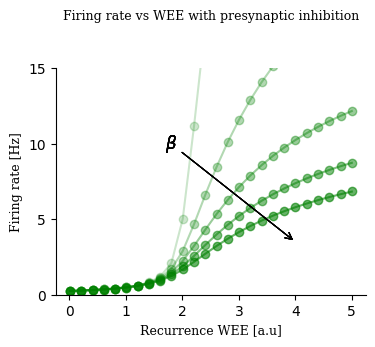

In [9]:
#Plot results

w = np.zeros((5,26))
wee_w = np.linspace(0.01,5.0,26) 
for i in range(5):
    w[i] = wee_w

l = [0.2,0.3,0.4,0.5,0.6]
font = {'family': 'serif',
        'color':  'black',
        'weight': 'normal',
        'size':9,
        }
fig, ax = plt.subplots(figsize=(4, 3), dpi=100)
for i in range(5): 
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)    
    ax.plot(w[i,np.nonzero(sim_ss[i])],sim_ss[i,np.nonzero(sim_ss[i])],"go",alpha=l[i])    
    ax.plot(w[i],ana_ss[i],color="g",alpha=l[i])
    plt.title("Firing rate vs WEE with presynaptic inhibition",pad=35,fontdict=font)
    plt.ylabel("Firing rate [Hz]",fontdict=font)
    plt.xlabel("Recurrence WEE [a.u]",fontdict=font)
    plt.ylim(0,15)
    plt.yticks(np.arange(0,16,5))
    plt.annotate(
     # Label and coordinate
    '${β}$', xy=(4,3.5),xytext=(1.8,10) ,
    horizontalalignment="center",fontsize=12,
    # Custom arrow
    arrowprops=dict(arrowstyle='->',lw=0.8),
    va='center'
    )
    
plt.show()